# 0. Введение

На текущий момент мы уже нашли на изображении слова и научились распознавать символы, из которых они состоят. Теперь у нас есть набор слов или кусков предложений, но пока что никак не связанных друг с другом. 

Для того, чтобы получить связный текст из этих кусков, необходимо связать полученные кусочки друг с другом. Этим мы и займемся в этом ноутбуке.

В этом ноутбуке мы будем использовать модель, которая слабо отличается от модели, которая находит слова. Поэтому мы не будем обучать какую-либо новую модель. Вместо этого мы возьмем уже обученную модель, которая умеет находить строки, и будем на основе нее собирать строки.

Следующие несколько ячеек будут общими для всех последующих ноутбуков.

* Эта ячейка настраивает отображение ipython widgets

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%matplotlib inline

* Подключаем Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


* Указываем путь к папке с кодом: 

In [ ]:
repo_folder = '/content/drive/MyDrive/github/'

* Устанавливаем зависимости

In [ ]:
reqs_path = repo_folder + 'IntelligentDocumentProcessing/requirements.txt '
!pip3 install -r {reqs_path}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 25.1 MB/s 
     |████████████████████████████████| 604 kB 36.8 MB/s 
     |████████████████████████████████| 707 kB 51.5 MB/s 
     |████████████████████████████████| 102 kB 10.4 MB/s 
     |████████████████████████████████| 49.9 MB 1.2 MB/s 
     |████████████████████████████████| 50 kB 7.3 MB/s 
     |████████████████████████████████| 5.3 MB 47.6 MB/s 
     |████████████████████████████████| 101 kB 10.7 MB/s 
     |████████████████████████████████| 175 kB 53.8 MB/s 
     |████████████████████████████████| 182 kB 70.6 MB/s 
     |████████████████████████████████| 168 kB 86.7 MB/s 
     |████████████████████████████████| 512 kB 59.2 MB/s 
     |████████████████████████████████| 2.1 MB 55.5 MB/s 
     |████████████████████████████████| 7.6 MB 57.9 MB/s 
     |████████████████████████████████| 182 kB 88.6 MB/s 
     |███████████████████████████

* Подключаем WandB

In [ ]:
import wandb
wandb_key = open('/content/drive/MyDrive/ssh/wandbkey.txt').read()
wandb.login(key=wandb_key)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

* Подключаем утилиты для этого ноутбука

In [ ]:
import sys
base_folder = repo_folder + 'IntelligentDocumentProcessing/Resources/c_Layout_Analisys/'  # import utils
sys.path.append(base_folder)
sys.path.append(repo_folder + 'IntelligentDocumentProcessing/Resources/')  # from a_Text_Detection.utils import
sys.path.append(repo_folder)  # from IntelligentDocumentProcessing.Resources.a_Text_Detection.utils import

# 1. Данные

## 1.1. Аугментации для данных

Для того, чтобы протестировать устойчивость модели к разнообразным изменениям документа, будем использовать аугментации во время тестирования решения.

In [ ]:
import albumentations as A
import cv2

transform = A.Compose([
    A.Perspective(p=0.7),
    A.OpticalDistortion(p=0.7, distort_limit=0.1, shift_limit=0.2, 
                        border_mode=cv2.BORDER_CONSTANT, value=0),
    A.ShiftScaleRotate(rotate_limit=10, shift_limit=0, p=0.7, 
                       border_mode=cv2.BORDER_CONSTANT, value=0),
])

## 1.2. Визуальный анализ изображений

Посмотрим, как выглядят тестовые данные (после аугментаций) для этой задачи.

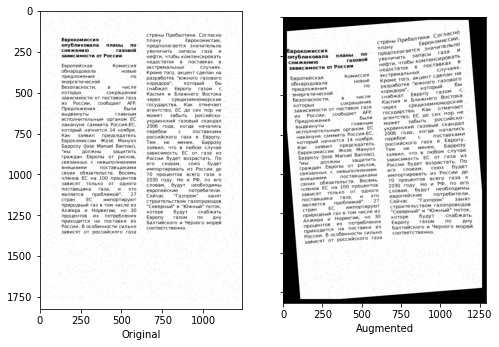

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt

image_dir = '/content/drive/MyDrive/data/la_data/c_Layout_Analisys_data/'
image_fpaths = Path(image_dir).glob("*.jpg")

for fpath in list(image_fpaths)[:1]:
    original_image = cv2.imread(str(fpath))
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    image = transform(image=original_image)['image']
    h, w, _ = image.shape
    # Добавляем по всем краям небольшой паддинг для того, чтобы координаты линий
    # не выходили за пределы изображения. Это можно делать более умно и сложно,
    # но пока что можно и так:)
    pad_transform = A.PadIfNeeded(min_height=h+50, min_width=w+50, border_mode=cv2.BORDER_CONSTANT, value=0)
    image = pad_transform(image=image)['image']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,12))
    ax1.set_xlabel('Original')
    ax2.set_xlabel('Augmented')
    ax1.imshow(original_image)
    ax2.imshow(image)
    plt.show()

# 2. Пайплайн для скоринга строк

## 2.1. Напишем код для детектора строк

### Задача 1. Инференс детектора строк



Инференс детектора строк совпадает с инференсом детектора текста, но есть одно принципиальное различие: необходимо нормировать все ббоксы по высоте/ширине изображения, чтобы все координаты были в интервале от 0 до 1. Также нужно возвращать список объектов типа `Line`, в которых есть поля `bbox` и `normalized_bbox`.

#### Код

In [ ]:
from typing import Union, List

import torch
import torch.nn as nn
import numpy as np
from albumentations import BasicTransform, Compose, OneOf
from albumentations.pytorch import ToTensorV2

from c_Layout_Analisys.utils import Line
from a_Text_Detection.utils import DrawMore, Postprocessor

# КОД ДЛЯ СТУДЕНТА
def line_detector_inference(
    model: nn.Module, 
    image: np.ndarray, 
    transform: Union[BasicTransform, Compose, OneOf],
    postprocessor: Postprocessor,
    device: str = 'cpu',
) -> List[Line]:
    w, h, _ =image.shape
    print(w, h)
    # подготовка изображения (c помощью transform)
    preproc_image = torch.unsqueeze(transform(image=image)['image'], 0)

    print(preproc_image.shape)
    # предсказание модели (с помощью model)
    pred_image = line_model(preproc_image)
    print(preproc_image.shape)
    # постпроцессинг предсказаний (с помощью postprocessor)
    contours = postprocessor(h, w, 
                             pred_image[0].detach().numpy(), 
                             return_polygon=True)
    bboxs = np.array(list(map(lambda x: Postprocessor.get_mini_boxes(x)[0], contours[0][0])))    
    # создание списка объектов типа Line 
    lines = []
    for bbox_i, label_i in zip(bboxs, contours[1][0]):
      line = Line()
      line.bbox = bbox_i
      line.normalized_bbox = line.bbox / np.array([w, h])
      line.normalized_bbox = np.clip(line.normalized_bbox, 0, 1)                              
      
      line.label = label_i
      lines.append(line)

    return lines

size=2048
transform = A.Compose([

    A.Normalize(
        mean=[0, 0, 0],
        std=[1, 1, 1],
        max_pixel_value=255.,
        p=1.,
    ),
    ToTensorV2(p=1.)
])  # преобразование изображений

postprocessor = Postprocessor(
    unclip_ratio=1.5,
    binarization_threshold=0.3,
    confidence_threshold=0.55,
    min_area=1,
    max_number=1000
)

#### Проверка

In [ ]:
import torch

from c_Layout_Analisys.utils import resize_aspect_ratio


max_image_size = 2048
device='cpu'
line_model_path = '/content/drive/MyDrive/data/la_data/la.jit'
line_model = torch.jit.load(line_model_path, map_location=device)
line_model.eval();

image, _, _ = resize_aspect_ratio(image, square_size=max_image_size, interpolation=cv2.INTER_LINEAR)
image = image.astype(np.uint8)
lines = line_detector_inference(line_model, image, transform, postprocessor, device)

assert isinstance(lines, list), 'Метод line_detector_inference должен возвращать список!'
assert all(isinstance(line, Line) for line in lines), 'Метод line_detector_inference должен возвращать список объектов типа Line!'
for line in lines:
    assert isinstance(line.bbox, np.ndarray), 'Каждый bounding box должен быть типа np.ndarray!'
    assert isinstance(line.normalized_bbox, np.ndarray), 'Каждый нормализованный bounding box должен быть типа np.ndarray!'
    assert line.normalized_bbox.min() >= 0, "Все элементы нормализованного bounding box'а должны быть больше или равны 0!"
    assert line.normalized_bbox.max() <= 1, "Все элементы нормализованного bounding box'а должны быть меньше или равны 1!"

1824 1312
torch.Size([1, 3, 1824, 1312])
torch.Size([1, 3, 1824, 1312])


## 2.2. Визуализируем предсказания

Посмотрим, какие получются строки у детектора строк:

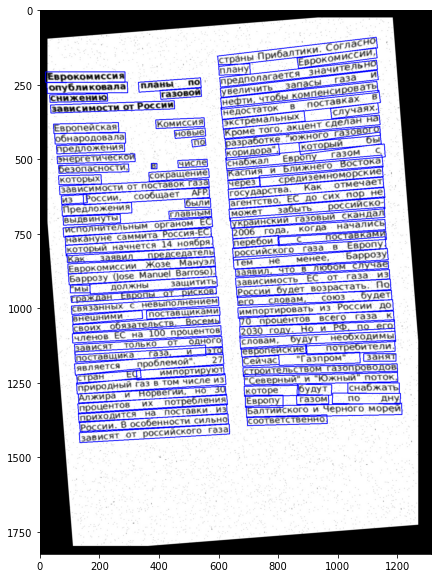

In [ ]:
vis_result = image.copy()
# vis_result = cv2.resize(vis_result, (size, size))
for line in lines:
    DrawMore.draw_contours(vis_result, [line.bbox], thickness=2, inplace=True, color=(0, 0, 255))

plt.figure(figsize=(10, 10))
plt.imshow(vis_result)

# 3. Пайплайн сборки линий в параграфы

## 3.1. Каждую строку будем сравнить с другой по трем метрикам:

- parallelness - параллельность строк в одном параграфе. Строки параллельны друг другу, если $\angle(l_1, l_2) \leq \theta$
- distance - расстояние между двумя строками, в оригинальной статье perpendicular proximity (перпендикулярное расстояние между двумя строками)
- overlap - пересечение

### Задача 2. Реализация методов сравнения строк

Выше концептуально описаны способы сравнения строк. Вам необходимо реализовать 4 метода (каждый метод работает с нормализованными bounding box): 

- `_distance` - вертикальное расстрояние между двумя строками. Рассчитывается как евклидово расстояние между $y_{среднее}$ первой строки и $y_{среднее}$ второй строки;
- `_length` (необходимо для метода `_overlapping`) - длина линии. В нашем случае это будет евклидово расстояние между двумя первыми точками нормализованного bounding box; 
- `_overlapping` - рассчитывается следующим образом ($x_{ij}$ - это $x$ координата $j$-й точки $i$-й линии): 

$$\frac{min(x_{12}, x_{22}) - max(x_{11}, x_{21})}{length(line_{1})}$$

- `_angle` - угол между прямыми, задаваемыми первыми двумя точками каждой строки (можно рассчитать с помощью `math.atan`). Угол обязательно должен быть приведен к величине от -90 до 90 градусов. 

Все эти методы будут являться частью класса `ParagraphFinder`, частично реализованного ниже. Алгоритм сборки линий в параграфы (метод `find_paragraphs`) будет выглядеть следующим образом: 

1. Кластеризация входных линий с помощью алгоритма `DBSCAN` с метрикой, основанной на вычислении `_angle`, `_overlapping` и `_distance`;
2. Нахождение bounding box для параграфа;
3. Сортировка линий внутри параграфа и параграфов внутри страницы.

#### Код

In [ ]:
import math

from sklearn.cluster import DBSCAN

from c_Layout_Analisys.utils import sort_boxes_top2down_wrt_left2right_order, sort_boxes, fit_bbox, Paragraph

# КОД ДЛЯ СТУДЕНТА
class ParagraphFinder:
    def __init__(
        self, 
        angle_threshold: int = 10, 
        overlapping_threshold: float = 0.3, 
        max_distance: int = 1,
        cluster_eps: float = 0.5
    ):
        self.angle_threshold = angle_threshold
        self.overlapping_threshold = overlapping_threshold
        self.max_distance = max_distance
        self.cluster_eps = cluster_eps
    
    @staticmethod
    def _distance(line1: Line, line2: Line) -> float:
        return ((np.mean(line1.normalized_bbox[:, 1]) - np.mean(line2.normalized_bbox[:, 1]))**2)**0.5

    @staticmethod
    def _length(line: Line) -> float:
        return np.sum((line.normalized_bbox[0, :] - line.normalized_bbox[1, :])**2)**0.5 

    def _overlapping(self, line1: Line, line2: Line) -> float:
        overlapping =(min(line1.normalized_bbox[1, 0], line2.normalized_bbox[1, 0]) 
                    - max(line1.normalized_bbox[0, 0], line2.normalized_bbox[0, 0])) / self._length(line1)
        if overlapping < 0:
          return 0
        return overlapping
    
    @staticmethod
    def _dot(self, line1: Line, line2: Line):
        return np.sum(np.dot(line1.normalized_bbox[:2], line2.normalized_bbox[:2]))

    @staticmethod
    def _angle(line1: Line, line2: Line) -> float:
        x1, y1 = line1.normalized_bbox[1,] - line1.normalized_bbox[0,]
        x2, y2 = line2.normalized_bbox[1,] - line2.normalized_bbox[0,]

        return math.degrees(math.atan(y2/x2)-math.atan(y1/x1))


    def paragraph_distance(self, line1: np.ndarray, line2: np.ndarray) -> float:
        line1 = Line(normalized_bbox=line1.reshape(4, 2))
        line2 = Line(normalized_bbox=line2.reshape(4, 2))

        if abs(self._angle(line1, line2)) > self.angle_threshold:
            return self.max_distance

        if self._overlapping(line1, line2) < self.overlapping_threshold:
            return self.max_distance

        return self._distance(line1, line2)
    
    @staticmethod
    def prepare_lines(lines: List[Line]) -> np.ndarray:
        return np.array([line.normalized_bbox.reshape(-1) for line in lines])
    
    def fit_cluster(self, lines: List[Line]) -> DBSCAN: 
        prepared_lines = self.prepare_lines(lines)
        cluster = DBSCAN(metric=self.paragraph_distance, eps=self.cluster_eps)
        cluster.fit(prepared_lines)
        return cluster
    
    @staticmethod
    def sort_paragraphs(paragraphs):
        for par in paragraphs:
            par.items = sort_boxes(par.items, sorting_type = 'top2down')  # сортировка сверху вниз
        paragraphs = sort_boxes_top2down_wrt_left2right_order(paragraphs)  # сортировка в порядке чтения
        return paragraphs
    
    def find_paragraphs(self, lines: List[Line]) -> List[Paragraph]:
        cluster = self.fit_cluster(lines)
        
        paragraphs = []
        for label in set(cluster.labels_):
            line_indexes = np.argwhere(cluster.labels_ == label)
            par_lines = [lines[idx[0]] for idx in line_indexes]
            bbox = fit_bbox(np.array([lines[idx[0]].bbox for idx in line_indexes]))
            par = Paragraph(items=par_lines, bbox=bbox)
            paragraphs.append(par)
        paragraphs = self.sort_paragraphs(paragraphs)
        return paragraphs

#### Проверка

In [ ]:
paragraph_finder = ParagraphFinder()

# возьмем две конкретных линии для проверки
norm_bbox_1 = np.array(
    [[0.47996795, 0.41517857],
     [0.8557692 , 0.43136162],
     [0.85336536, 0.45200893],
     [0.4775641 , 0.43582588]]
)
line1 = Line(bbox=np.array([]), normalized_bbox=norm_bbox_1)
norm_bbox_2 = np.array(
    [[0.48076922, 0.3950893 ],
     [0.8733974 , 0.41238838],
     [0.8709936 , 0.4330357 ],
     [0.4783654 , 0.41573662]]
)
line2 = Line(bbox=np.array([]), normalized_bbox=norm_bbox_2)

# _length
assert round(paragraph_finder._length(line1), 4) == 0.3761, 'Что-то не так с методом _length...'
assert round(paragraph_finder._length(line2), 4) == 0.393, 'Что-то не так с методом _length...'

# _distance
assert round(paragraph_finder._distance(line1, line2), 4) == 0.0195, 'Что-то не так с методом _distance...'

# _overlapping
assert round(paragraph_finder._overlapping(line1, line2), 4) == 0.9969, 'Что-то не так с методом _overlapping...'

# _angle
assert round(paragraph_finder._angle(line1, line2), 4) == 0.057, 'Что-то не так с методом _angle...'

Код готов, для правильной работы осталось только подобрать оптимальные значения параметров. Параметры `angle_threreshold` и `max_distance` мы оставим такими же, как и в конструкторе, а вот `overlapping_threshold` и `cluster_eps` необходимо подобрать. 

### Задача 3.1. Подбор параметра `overlapping_threshold`

`overlapping_threshold` можно подобрать достаточно просто - взять `lines` с нашего изображения, для всех возможных пар строк посчитать значение функции `paragraph_finder._overlapping` и построить по ним распределение частот. В распределениии будет видно, какое значение хорошо разделит параграфы;

#### Код

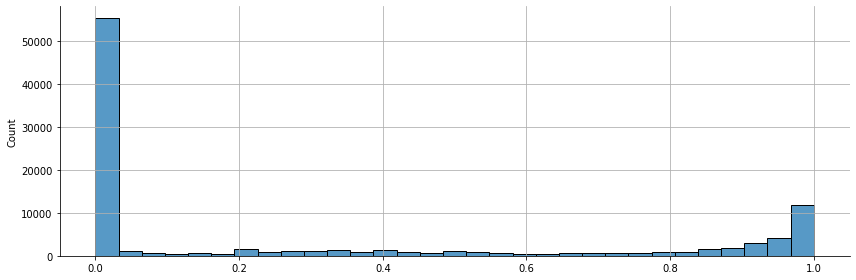

In [ ]:
# КОД ДЛЯ СТУДЕНТА
import seaborn as sns


overlapings = []
for i in range(100000):
  line1, line2 = np.random.choice(lines, 2)
  if np.any(line1.bbox != line2.bbox):
    overlaping = paragraph_finder._overlapping(line1, line2)
    overlapings.append(overlaping)
sns.displot(overlapings,height=4, aspect=3)
plt.grid()

overlapping_threshold = 0.1

In [ ]:
# КОД ДЛЯ СТУДЕНТА

overlapping_threshold = 0.1

#### Проверка

In [ ]:
assert 0.1 <= overlapping_threshold <= 0.5

### Задача 3.2. Подбор параметра `cluster_eps`

Данный параметр можно подобрать так называемым elbow method. Для начала необходимо подготовить строки с помощью метода `prepare_lines` из класса `ParagraphFinder`. Затем мы обучаем метод `NearestNeighbors` с параметром `n_neighbors=2`. Зачем мы это делаем? Для того, чтобы найти для каждой строки ближайшего соседа, вычислить до него расстояние и по графику расстояний определить оптимальное значение `cluster_eps` (а это не что иное, как граничное расстояние между двумя элементами кластера). 

Соответственно, обучив `NearestNeighbors`, необходимо найти для каждой строки соседа и посчитать расстояния от каждой линии до ближайшего соседа. Затем, отсортировав эти расстояния и построив график, вы должны получить примерно следующее: 

<img src='https://miro.medium.com/max/1014/1*KUYsoRqDm5vVYX9qHB-xeQ.png'>

На графике надо найти точку с максимальной кривизной, на картинке выше это примерно значение 0.3 - это и будет искомый параметр `cluster_eps`. 

In [ ]:
cluster_eps = 0.3

#### Код

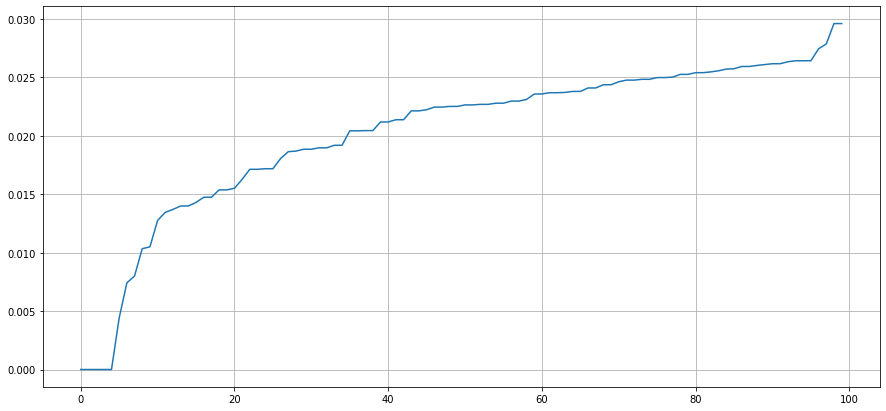

In [ ]:
from sklearn.neighbors import NearestNeighbors

prepared_lines = paragraph_finder.prepare_lines(lines)
knn = NearestNeighbors(metric=paragraph_finder.paragraph_distance)
knn.fit(prepared_lines)

nbors = knn.kneighbors(prepared_lines, 2, return_distance=False)
nbors_dist = [paragraph_finder._distance(lines[i], lines[j]) for (i, j) in nbors]

plt.figure(figsize=(15, 7))
plt.plot(np.sort(nbors_dist))
plt.grid()

In [ ]:
preproc_image = 0.1
c = 0.1

#### Проверка

In [ ]:
assert 0.1 <= c <= 0.3

In [ ]:
cluster_eps

0.3

# 4. Визуализация результата

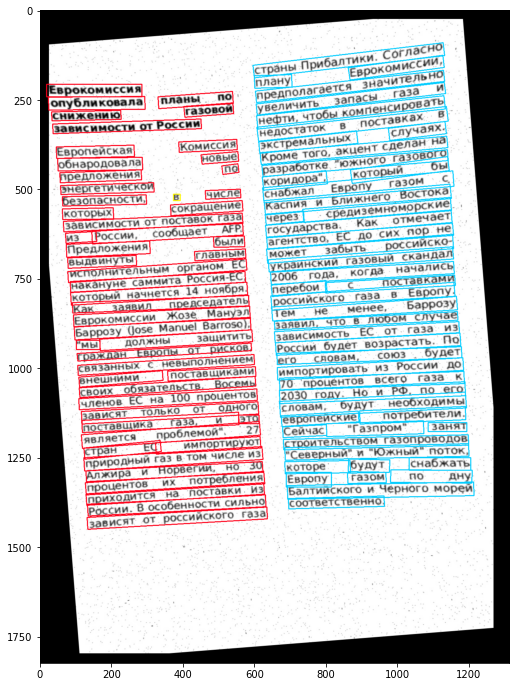

In [ ]:
from c_Layout_Analisys.utils import get_random_color, draw_paragraphs

paragraph_finder = ParagraphFinder(overlapping_threshold=overlapping_threshold, cluster_eps=cluster_eps)
paragraphs = paragraph_finder.find_paragraphs(lines)
draw_paragraphs(image, paragraphs)

Сохраним объект `ParagraphFinder` для использования при сборке приложения:

In [ ]:
import dill

with open('paragraph_finder.pkl', 'wb') as w:
    dill.dump(paragraph_finder, w)

Также предлагаем вам интерактивно изменять параметры `angle_threshold`, `overlapping_threshold` и `cluster_eps` и смотреть, как от этого изменятся параграфы. 

In [ ]:
from ipywidgets import interact, IntSlider, FloatSlider, fixed

def wrapper(image, lines, angle_threshold=10, overlapping_threshold=0.3, cluster_eps=0.5):
    paragraph_finder = ParagraphFinder(angle_threshold, overlapping_threshold, 1, cluster_eps)
    paragraphs = paragraph_finder.find_paragraphs(lines)
    print('Количество параграфов:', len(paragraphs))
    draw_paragraphs(image, paragraphs)
    
interact(
    wrapper, 
    image=fixed(image), 
    lines=fixed(lines), 
    angle_threshold=IntSlider(min=0, max=50, step=5, value=10),
    overlapping_threshold=FloatSlider(min=0, max=1, step=0.05, value=0.3),
    cluster_eps=FloatSlider(min=0.01, max=1.5, step=0.05, value=0.5)
);

interactive(children=(IntSlider(value=10, description='angle_threshold', max=50, step=5), FloatSlider(value=0.…

### Задача 4 (опциональная). Визуализация порядка строк

Вам необходимо дополнить функцию `draw_paragraphs` (можно найти в файле `IntelligentDocumentProcessing/Resources/3_Layout_Analisys/utils/utils.py`) отрисовкой номеров строк. Для этого можно использовать метод `cv2.putText`. Примерный алгоритм:

1. Пишем цикл по всем параграфам;
2. В каждом параграфе выбираем цвет и пишем цикл по всем линиям;
3. В каждой линии рисуем boudning box этой лини;
4. Также в кажжой линии с помощью `cv2.putText` рисуем текст с номером этой линии в этом параграфе (в качестве координат можно выбрать одну из точек линии);
5. Отрисовываем изображение с помощью `plt.imshow`. 

#### Код

In [ ]:
# КОД ДЛЯ СТУДЕНТА
def draw_paragraphs_with_line_idx(image: np.ndarray, paragraphs: List[Paragraph]) -> None:
    paragraph_result_image = image.copy()       
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 1
    for paragr in paragraphs:
        color, ind = get_random_color(), 1
        for line in paragr.items:
            DrawMore.draw_contours(paragraph_result_image, [line.bbox],
                                   color=color, thickness=4, 
                                   inplace=True)
            paragraph_result_image = cv2.putText(paragraph_result_image, 
                                                 text=str(ind), 
                                                 org=tuple(map(int, tuple(line.bbox[0]))),
                                                 fontFace=font, 
                                                 fontScale=fontScale, color=(0, 0, 0), 
                                                 thickness=4, 
                                                 lineType=cv2.LINE_AA, 
                                                bottomLeftOrigin=False
                                                 )
            ind += 1
    plt.figure(figsize=(15, 12))
    plt.imshow(paragraph_result_image)

#### Проверка

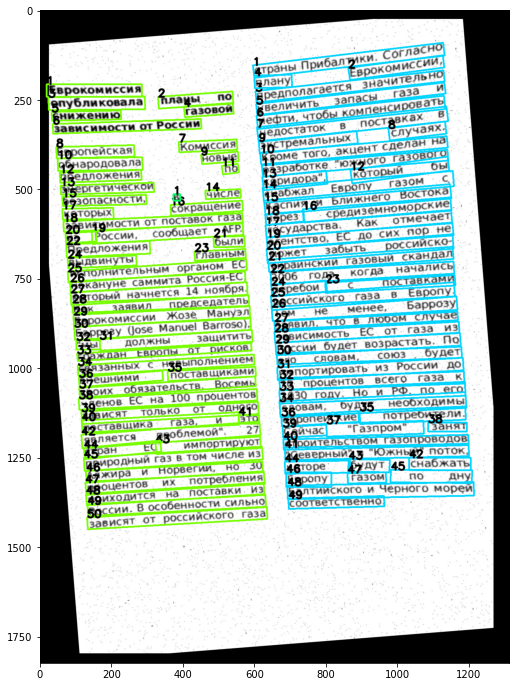

In [ ]:
draw_paragraphs_with_line_idx(image, paragraphs)

# 5. Подведение итогов

В этой тетрадке мы познакомились с одним из методов анализа структуры текста, а подробнее:
- Написали инференс модели детекции строк в формате `TorchScript`;
- Частично реализовали метод сборки линий в параграфы; 
- Оптимизировали гиперпараметры алгоритма сборки линий в параграфы;
- Визуализировали результаты анализа структуры текста.

Основная часть пайплайна, которая связана с обработкой изображений, выполнена. Далее мы плавно переходим из CV в NLP и займемся анализом текстов, распознанных на изображениях. 